In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import time
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt



In [42]:
# Crear carpetas para imágenes
output_dirs = ["dataset/piedra", "dataset/papel", "dataset/tijeras"]
for dir in output_dirs:
    os.makedirs(dir, exist_ok=True)


# Inicialización
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1)
mp_draw = mp.solutions.drawing_utils

# Datos
data = []
labels = []

# Captura desde webcam
cap = cv2.VideoCapture(0)

print("Presiona 0 para piedra, 1 para papel, 2 para tijeras. ESC para salir.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(frame_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            coords = []
            for lm in hand_landmarks.landmark:
                coords.append(lm.x)
                coords.append(lm.y)
            
            instrucciones = "Presiona 0 (Piedra), 1 (Papel), 2 (Tijeras), ESC (salir)"
            cv2.putText(frame, instrucciones, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            key = cv2.waitKey(1)

            if key in [ord('0'), ord('1'), ord('2')]:
                label = int(chr(key))
                data.append(coords)
                labels.append(label)

                # Guardar imagen en carpeta correspondiente
                label_name = ["piedra", "papel", "tijeras"][label]
                filename = f"{int(time.time() * 1000)}.jpg"  # nombre único por timestamp
                save_path = os.path.join("dataset", label_name, filename)
                cv2.imwrite(save_path, frame)

                # Mostrar y guardar feedback
                gesto = ["Piedra", "Papel", "Tijeras"][label]
                print(f"[✓] Gesto guardado: {gesto} ({label}) - Imagen: {save_path}")

                
                # Mostrar el gesto en pantalla por 1 segundo
                cv2.putText(frame, f"Grabado: {gesto}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 3)
                cv2.imshow("Grabando dataset", frame)
                cv2.waitKey(1000)  # Pausa 1 segundo para ver el mensaje


    cv2.imshow("Grabando dataset", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

np.save("rps_dataset.npy", np.array(data))
np.save("rps_labels.npy", np.array(labels))



Presiona 0 para piedra, 1 para papel, 2 para tijeras. ESC para salir.
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279103550.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279107824.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279111181.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279115131.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279119215.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279124738.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279132015.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279137679.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279143372.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279146145.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279148288.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\1745279150013.jpg
[✓] Gesto guardado: Papel (1) - Imagen: dataset\papel\174527915169

In [43]:
# 1. Cargar los datos
X = np.load("rps_dataset.npy")  # Shape: (n_samples, 42)
y = np.load("rps_labels.npy")   # Shape: (n_samples,)

# 2. Escalar los datos (opcional pero recomendado)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Codificar etiquetas (one-hot) para clasificación con softmax
y_cat = to_categorical(y, num_classes=3)

# 4. Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)

# 5. Crear la red neuronal
model = Sequential([
    Input(shape=(42,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 clases: piedra, papel, tijeras
])

# 6. Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 7. Entrenar el modelo
history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.2)

# 8. Evaluar el modelo
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Precisión en test: {acc*100:.2f}%")

# 9. Guardar el modelo entrenado y el scaler
model.save("rps_model.h5")
np.save("rps_scaler_mean.npy", scaler.mean_)
np.save("rps_scaler_scale.npy", scaler.scale_)

print("🧠 Modelo y scaler guardados correctamente.")


Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3479 - loss: 1.2846 - val_accuracy: 0.5000 - val_loss: 1.0645
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4320 - loss: 1.0726 - val_accuracy: 0.5000 - val_loss: 1.0363
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5412 - loss: 0.9368 - val_accuracy: 0.5833 - val_loss: 1.0018
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6412 - loss: 0.8445 - val_accuracy: 0.7083 - val_loss: 0.9377
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7132 - loss: 0.7575 - val_accuracy: 0.6667 - val_loss: 0.8698
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8521 - loss: 0.6836 - val_accuracy: 0.7083 - val_loss: 0.8156
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9039 - loss: 0.6265 - val_accuracy: 0.7083 - val_loss: 0.7672
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9228 - loss: 0.5476 - val_accuracy: 0.7083 - val_loss:


✅ Precisión en test: 100.00%
🧠 Modelo y scaler guardados correctamente.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


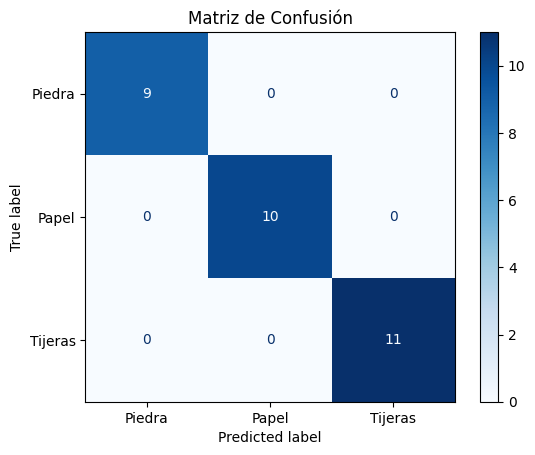

In [ ]:
# 1. Obtener etiquetas verdaderas (convertir one-hot a clase)
y_true = np.argmax(y_test, axis=1)

# 2. Predecir clases con el modelo
y_pred = np.argmax(model.predict(X_test), axis=1)

# 3. Calcular matriz de confusión
matriz = confusion_matrix(y_true, y_pred)

# 4. Etiquetas de clase
clases = ["Piedra", "Papel", "Tijeras"]

# 5. Mostrar matriz
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=clases)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


In [46]:
# 1. Cargar modelo y scaler
model = load_model("rps_model.h5")
scaler_mean = np.load("rps_scaler_mean.npy")
scaler_scale = np.load("rps_scaler_scale.npy")

# Función para escalar como en entrenamiento
def scale_input(X):
    return (X - scaler_mean) / scaler_scale

# 2. Inicializar MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1)
mp_draw = mp.solutions.drawing_utils

# 3. Mapeo de etiquetas
clases = ["Piedra", "Papel", "Tijeras"]

# 4. Captura desde webcam
cap = cv2.VideoCapture(0)

print("🙌 Mostrá un gesto y el sistema lo va a clasificar en tiempo real...\nPara guardar una imagen presiona la barra espaciadora")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(frame_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            coords = []
            for lm in hand_landmarks.landmark:
                coords.append(lm.x)
                coords.append(lm.y)

            X_input = scale_input(np.array(coords).reshape(1, -1))
            prediction = model.predict(X_input, verbose=0)
            class_id = np.argmax(prediction)
            prob = prediction[0][class_id]

            label = f"{clases[class_id]} ({prob*100:.1f}%)"
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            cv2.putText(frame, label, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    cv2.imshow("Rock Paper Scissors", frame)

    key = cv2.waitKey(1) & 0xFF

    if key == 32:  # 32 es el código ASCII de la barra espaciadora
        timestamp = int(time.time() * 1000)
        filename = os.path.join("capturas", f"captura_{timestamp}.jpg")
        os.makedirs("capturas", exist_ok=True)
        cv2.imwrite(filename, frame)
        print(f"[📸] Imagen guardada como {filename}")

    if cv2.waitKey(1) & 0xFF == 27:  # ESC para salir
        break

cap.release()
cv2.destroyAllWindows()


🙌 Mostrá un gesto y el sistema lo va a clasificar en tiempo real...
Para guardar una imagen presiona la barra espaciadora
[📸] Imagen guardada como capturas\captura_1745279927827.jpg
[📸] Imagen guardada como capturas\captura_1745279938019.jpg
[📸] Imagen guardada como capturas\captura_1745279941498.jpg
[📸] Imagen guardada como capturas\captura_1745279944957.jpg
[📸] Imagen guardada como capturas\captura_1745279952886.jpg
[📸] Imagen guardada como capturas\captura_1745279955628.jpg
[📸] Imagen guardada como capturas\captura_1745279963954.jpg
[📸] Imagen guardada como capturas\captura_1745279973109.jpg
[📸] Imagen guardada como capturas\captura_1745279979092.jpg
[📸] Imagen guardada como capturas\captura_1745279982081.jpg
[📸] Imagen guardada como capturas\captura_1745279984617.jpg
[📸] Imagen guardada como capturas\captura_1745279987424.jpg
[📸] Imagen guardada como capturas\captura_1745279990034.jpg
[📸] Imagen guardada como capturas\captura_1745280006060.jpg
[📸] Imagen guardada como capturas\capt